# Dynamic Time Warping

**Objetivos**
1. Implementar o algoritmo de DTW
1. Entender a diferença entre performances da mesma música

**Resultado Esperado**
1. Entendimento do Cromagrama
1. Entedimento da tarefa de alinhamento de músicas

In [1]:
from numba import jit

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

plt.rcParams['axes.labelsize']  = 16
plt.rcParams['axes.titlesize']  = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 2

plt.ion()

## Introdução

Como vimos em sala de aula, a tarefa de alinhamento de músicas tem diversas aplicações possíveis. Neste notebook, vamos explorar o conceito de *Dynamic Time Warping* para comparar diferentes versões de uma mesma música.

Em tarefas de Recuperação de Informação Musical, é comum comparar duas sequências de comprimentos diferentes. Por exemplo, um objetivo simples pode ser em calcular uma medida de similaridade entre duas versões da mesma música. Em outras palavras, entre dois sinais $x$ e $y$.

Tais sinais podem ter sequências semelhantes de progressões de acordes e instrumentações. Porém, podem haver desvios de batidas por minuto entre os dois. Para entender melhor, compare as duas versões da mesma música abaixo.

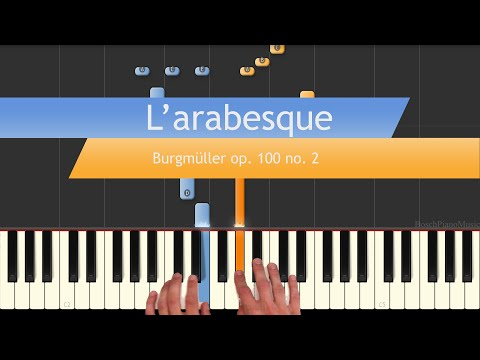

In [2]:
ipd.YouTubeVideo('ZTJ0AYKNdgI')

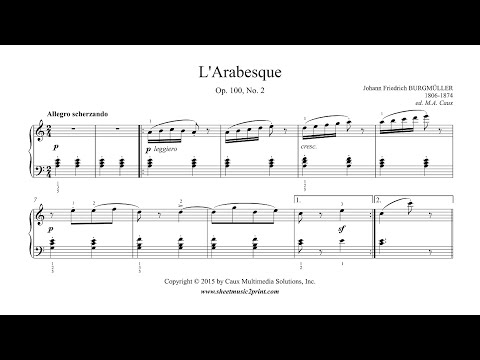

In [3]:
ipd.YouTubeVideo('1oMm_n38OxQ')

Observe como cada versão diferente tem uma duração distinta. Mesmo que expressássemos os dois sinais de áudio usando o mesmo espaço de recursos (por exemplo, espectrogramas), não poderíamos simplesmente usar uma distâncias entre pares simples. Os sinais têm comprimentos diferentes (4 segundos de diferença).

Como visto em sala de aula, o problema de alinhamento de músicas tem diversas aplicações nas bibliotecas digitais musicais. Uma delas, são aplicativos que permitem o chaveamento entre diferentes versões em um mesmo instante de tempo (na mesma nota). Uma outra é a análise de performance.

Para alinhar músicas vamos fazer uso de *Dynamic Time Warping*.

## Dynamic Time Warping

### Do Wikipedia

Dynamic time warping (DTW) é um algoritmo para comparar e alinhar duas séries temporais. A DTW é utilizada para encontrar o alinhamento não-linear ótimo entre duas sequências de valores numéricos. Dessa maneira, é possível encontrar padrões entre medições de eventos com diferentes ritmos. Por exemplo, é possível casar a série temporal obtida por acelerômetros (ou outros sensores) de duas pessoas andando em diferentes velocidades.

DTW pode ser utilizada para alinhar qualquer tipo de dado que obedeça uma ordem temporal, como vídeo, áudio e imagens. Entre as diversas aplicações da DTW, encontra-se o reconhecimento de fala e de assinatura, bem como o alinhamento de gravações musicais com suas respectivas partituras.

**Exemplo**

Para entender o algoritmo, vamos criar duas vetores de tamanhos distintos.

In [4]:
x = np.array([1, 4, 4, 2, -4, -4, 9])
y = np.array([1, 3, 4, 3, 1, -1, -2, -1, 12])
nx = len(x)
ny = len(y)

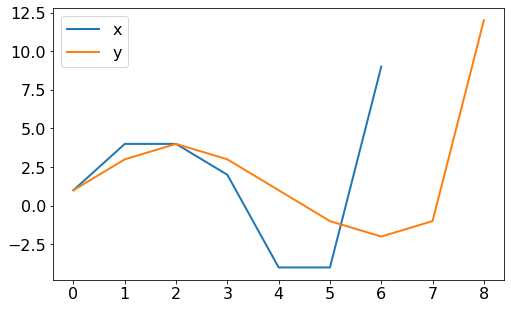

In [5]:
fig, ax = plt.subplots(figsize=(1.618 * 5, 5))
ax.plot(x)
ax.plot(y)
ax.legend(('x', 'y'))

Neste exemplo simples, há apenas um valor ou "atributo" em cada índice de tempo. Na prática, você pode usar sequências de vetores, por exemplo, espectrogramas ou cromogramas.

### Distância

O DTW requer o uso de uma métrica de distância entre as observações correspondentes de $x$ e $y$. 

**Euclidiana**

Uma escolha comum é a distância euclidiana.

$$d(\mathbf{f}_1, \mathbf{f}_2) = || \mathbf{f}_1 - \mathbf{f}_2 || = \sqrt{\sum_i (\mathbf{f}_1[i] - \mathbf{f}_2[i])^2}$$

Observe como os vetores aqui tem as mesmas dimensões. Tal dimensão **não é o tempo**, sim o **número de observações por tempo**. No exemplo acima temos apenas uma observação por tempo. Porém, ao fazer o cromagrama de uma música, vide abaixo, teremos 12 observações por tempo.

No exemplo abaixo temos duas observações por tempo.

In [6]:
import scipy.spatial as ss
ss.distance.euclidean([1, 0], [5, 12])

12.649110640673518

**Coseno**

Uma outra métrica de distância é o 1-coseno. Quando dois vetores apontam na mesma direção, o coseno entre os mesmos é 1. Quando apontam em direções opostas, o coseno vira 0. Assim, vamo fazer 1-coseno vamos capturar uma noção de distância que não se importa com a magnitude dos valores, sim com a direção dos vetores.

![](./cos.png)

In [7]:
ss.distance.cosine([1, 0], [5, 12])

0.6153846153846154

Observe que magnitudes diferentes apontando na mesma direção dão o mesmo resultado.

In [8]:
ss.distance.cosine([1, 1], [9, 9])

0.0

### Cromagrama

Como vimos em sala de aula, podemos usar o **cromagrama**, ou **vetor de cromas**, para representar músicas. Um vetor de croma é um vetor de característica de 12 elementos. Cada elemento indica a quantidade de energia em um *semitom* {C, C #, D, D #, E, ..., B}.

Vamos comparar dois vetores de croma da mesma música usando librosa.

Carregando uma música com librosa. Vamos focar nos primeiros 15 segundos da música apenas. Nossa comparação será de duas versões da música [Body and Soul](https://en.wikipedia.org/wiki/Body_and_Soul_(1930_song)). 

**Do Wikipedia**

"Body and Soul" foi escrita para a atriz e cantora inglesa Gertrude Lawrence, sendo interpretada pela primeira vez por ela, ainda na Inglaterra. Libby Holman foi a responsável pelo lançamento da canção nos Estados Unidos. Inicialmente, a música foi proibida de ser executada nas estações de rádio do país, porém a popularidade da canção cresceu muito nas décadas de 1930 e 1940, sendo regravada por uma série de artistas. A primeira regravação de "Body and Soul" foi feita ainda em 1930 pelo cantor estadunidense Louis Armstrong, que após o seu lançamento alcançou o número 12 na parada de singles norte-americana. Até o final da década, a canção havia sido regravada por 11 grupos, senda a mais bem-sucedida nas paradas a versão original da canção lançada por Libby Holman tando atingido o número 3. "Body and Soul" continua a ser um padrão de jazz, com centenas de versões cantadas e gravadas por dezenas de artistas. Clássicas gravações vocais incluem as de: Ella Fitzgerald, Hanshaw Annette, Billie Holiday, Billy Eckstine , Etta James , Sarah Vaughan e Frank Sinatra, e músicos como Benny Goodman, Lee Konitz, John Coltrane, Charles Mingus, Dexter Gordon, Sonny Stitt e Lester Young.

**MP3s**

Na pasta `mp3s` existem diferentes versões de Body and Soul. As mesmas foram identificadas com ajuda da base de dados chamada de [JazzTube](http://mir.audiolabs.uni-erlangen.de/jazztube). O JazzTube contém um série de referências a clássicos do Jazz no YouTube. Caso queira, explore a base pois pode ser uma fonte para projetos futuros.

O professor da disciplina baixou os mp3s do YouTube usando a ferramenta [youtube-dl](https://youtube-dl.org/). Abaixo segue um exemplo de uso da mesma, não precisa executar.

```bash
$ youtube-dl --extract-audio --audio-format mp3 https://www.youtube.com/watch?v=_OFMkCeP6ok
```

*Abaixo uma versão antiga de Chu Berry e Roy Eldridge*

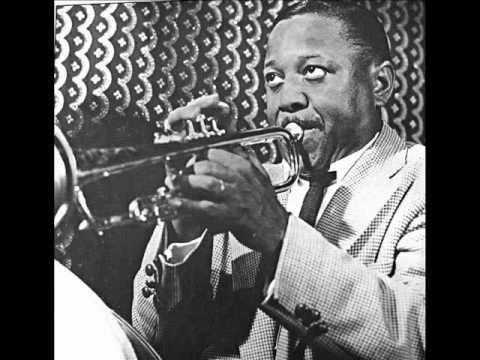

In [9]:
ipd.YouTubeVideo('Lor80WUVbtw')

In [10]:
wave_classic, sr = librosa.load('mp3s/Chu Berry , Roy Eldridge - BODY AND SOUL-Lor80WUVbtw.mp3',
                                duration=15)

/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


True

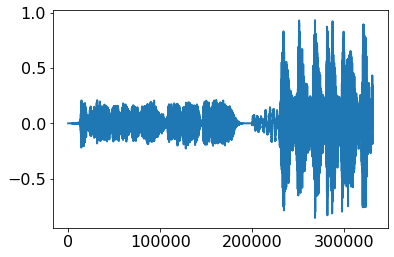

In [11]:
plt.plot(wave_classic)
sr
len(wave_classic) == sr*15

Vamos computar o cromograma da música com librosa.

In [12]:
chroma_classic = librosa.feature.chroma_stft(wave_classic, sr=sr)
chroma_classic.shape

(12, 646)

Plotar o mesmo.

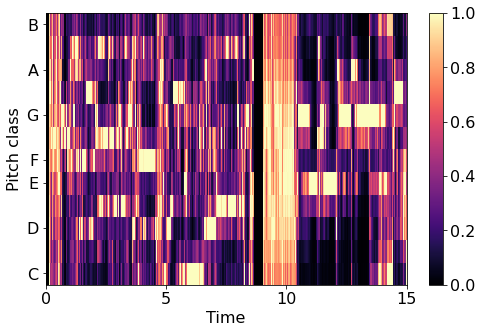

In [13]:
fig, ax = plt.subplots(figsize=(1.618 * 5, 5))
img = librosa.display.specshow(chroma_classic,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

*Agora uma versão mais nova de Tony Bennett e Amy Winehouse*

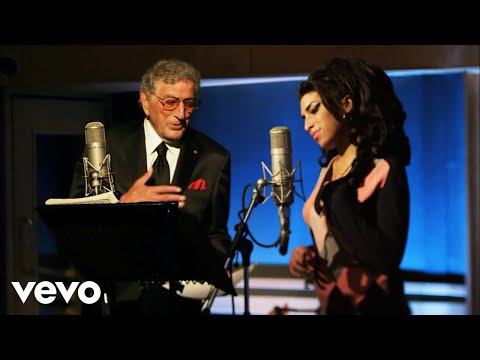

In [14]:
ipd.YouTubeVideo('_OFMkCeP6ok')

Tanto em áudio quanto em cromagrama, as duas versões são bem diferentes.

In [15]:
wave_amy, sr = librosa.load('mp3s/Tony Bennett, Amy Winehouse - Body and Soul (from Duets II - The Great Performances)-_OFMkCeP6ok.mp3',
                        duration=15)

/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


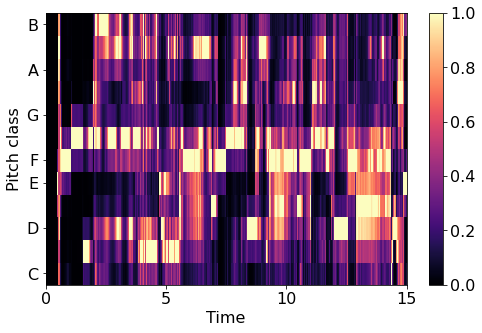

In [16]:
chroma_amy = librosa.feature.chroma_stft(wave_amy, sr=sr)
chroma_amy.shape
fig, ax = plt.subplots(figsize=(1.618 * 5, 5))
img = librosa.display.specshow(chroma_amy,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

Para comparar as duas com DTW, temos que computar a distância coseno entre as colunas.

In [17]:
print(chroma_classic[:, 0].shape)
print(chroma_amy[:, 1].shape)

(12,)
(12,)


Aqui observamos nosso primeiro problema, a presença de zeros leva a disância para `nan`. Portanto, é mais comum usar versões suavizadas do cromagrama.

In [18]:
ss.distance.cosine(chroma_classic[:, 0], chroma_amy[:, 0])

/home/abner/.local/lib/python3.8/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


nan

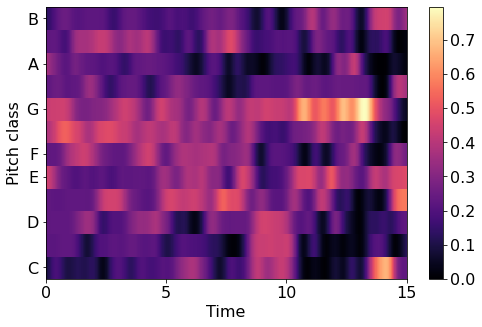

In [19]:
chroma_classic = librosa.feature.chroma_cens(wave_classic, sr=sr)
fig, ax = plt.subplots(figsize=(1.618 * 5, 5))
img = librosa.display.specshow(chroma_classic,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

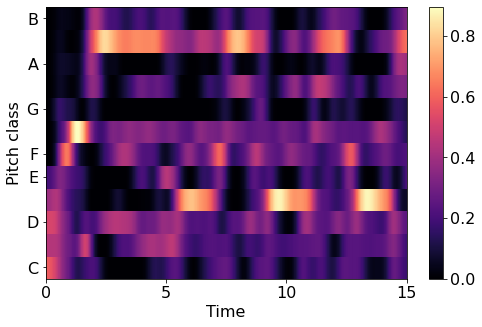

In [20]:
chroma_amy = librosa.feature.chroma_cens(wave_amy, sr=sr)
fig, ax = plt.subplots(figsize=(1.618 * 5, 5))
img = librosa.display.specshow(chroma_amy,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

Qual foi a ideia? Veja os slides das aula.

1. Tirar o log para ficar em uma *escala mais musical*
1. Somar uma pequena constante
1. Normalizar as colunas
1. Dentre outros

In [21]:
ss.distance.cosine(chroma_classic[:, 0], chroma_amy[:, 0])

0.5731591314954412

## Tarefa 1

Agora vamos programar. Sua primeira tarefa é implementar o Dynamic Time Warping. Seu código deve fazer uso de duas funções, uma para computar a matriz de custo. Esta se chama `dtw_table` abaixo. Pode usar a distância euclideana por simplicidade. 

![](./saida1.png)

**Questão 1**

Seu código deve gerar uma saída como a acima. Caso fique igual, 100%. Observe que a mesma não corresponde as saída do livros, Python indexa de cima para baixo. O livro de baixo para cima. De qualquer forma, isto é apenas um pequeno detalhe que não muda o algoritmo. Caso queira, mude o código para receber uma função de distância.

Seu código abaixo já vai receber matrizes onde as colunas são tempo e as linhas são observações.

In [22]:
def dtw_table(X, Y):
    '''
    Retorna a matriz de DTW entre as músicas.
    
    Argumentos
    ----------
    X: matriz onde as colunas são tempo e as linhas são atributos
    Y: matriz onde as colunas são tempo e as linhas são atributos
    ''' 
    n_x = X.shape[1]
    n_y = Y.shape[1]
    
    D = np.zeros(shape=(n_x, n_y), dtype='d')
 
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            D[i, j] = ss.distance.euclidean(X[:, i], Y[:, j])
    return D

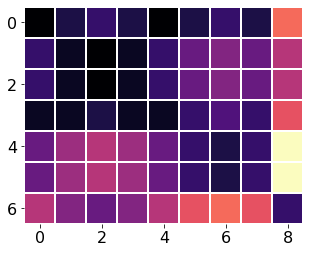

In [23]:
def plot_dtw_table(D, path=None):
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(D, cmap='magma')
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    
    ax.set_xticks(np.arange(D.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(D.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    if path:
        x = []
        y = []
        for n, m in path:
            y.append(n)
            x.append(m)
        ax.plot(x, y, color='r')
    
D = dtw_table(x[None], y[None]) # Não apagar isto é o teste!!!
plot_dtw_table(D)

**Questão 2**

Agora, crie uma função que retorna uma lista de tuplas. Esta lista contém o caminho ótimo do DTW. Para o exemplo acima com distância euclidiana, o caminho é:

```
[(6, 8),
 (5, 7),
 (5, 6),
 (4, 5),
 (3, 4),
 (3, 3),
 (2, 2),
 (1, 2),
 (1, 1),
 (0, 0)]
 ```
 
O plot agora deve ficar estilo a figura abaixo.

![](./saida2.png)

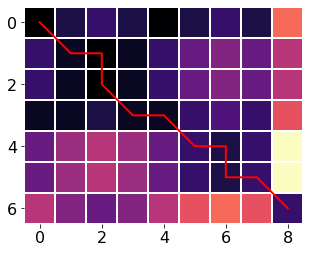

In [24]:
def dtw(X, Y):
    if X.ndim == 1:
        X = X[None]
        Y = Y[None]
        
    D = dtw_table(X, Y)
    
    n_x = X.shape[1]
    n_y = Y.shape[1]
    
    n = n_x - 1
    m = n_y - 1
    path = [(n, m)]
    
    while n > 0 or m > 0:
        if n == 0:
            while m > 0:
                m = m - 1
                path += [(n, m)]

        if m == 0:
            while n > 0:
                n = m - 1
                path += [(n, m)]
                
        if D[n - 1, m - 1] < D[n - 1, m] and D[n - 1, m - 1] < D[n, m - 1]:
            n = n - 1
            m = m - 1
        elif D[n - 1, m] < D[n, m - 1]:
            n = n - 1
        else:
            m = m - 1
        path += [(n, m)]
    return D, path

D, path = dtw(x, y)
plot_dtw_table(D, path)

## Tarefa 2

Usando a biblioteca [FastDTW](https://github.com/slaypni/fastdtw) ordena as versões das músicas que são mais e menos similares com a versão de Tony Bennet e Amy Winehouse

```bash
$ pip install fastdtw
```

A biblioteca FastDTW é interessante pois é toda linear em tempo e memória. Assim, podemos computar a distância entre versões inteiras de músicas. Faça isso. Caso não execute, trunque em 2mins. Caso não execute, trunque em 1 min.

Abaixo executo a FastDTW com os 15 segundos que carregamos antes. Observe como passo a transposta, pois a biblioteca funciona em linhas, não em colunas, como o livro.

In [25]:
from fastdtw import fastdtw
x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(chroma_amy.T, chroma_classic.T, dist=ss.distance.cosine)

In [26]:
wave_amy, sr = librosa.load('mp3s/Tony Bennett, Amy Winehouse - Body and Soul (from Duets II - The Great Performances)-_OFMkCeP6ok.mp3',
                        duration=180)
chroma_amy = librosa.feature.chroma_cens(wave_amy, sr=sr)

/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [27]:
import os
files = os.listdir('mp3s')
files.remove('Tony Bennett, Amy Winehouse - Body and Soul (from Duets II - The Great Performances)-_OFMkCeP6ok.mp3')
distances = np.array([])

#dados das versões mais e menos similares
distancia_mais = np.inf
distancia_menos = np.inf*(-1)
path_mais = []
path_menos = []
chroma_mais = np.array([])
chroma_menos = np.array([])
versao_mais = ''
versao_menos = ''

for filename in files:
    print("Processando " + filename)
    wave, sr = librosa.load('mp3s/' + filename, duration=180)
    chroma = librosa.feature.chroma_cens(wave, sr=sr)
    distance, path = fastdtw(chroma_amy.T, chroma.T, dist=ss.distance.cosine)
    distances = np.append(distances, distance)
    
    if (distance < distancia_mais):
        distancia_mais = distance
        path_mais = path
        chroma_mais = chroma
        versao_mais = filename
    
    if (distance > distancia_menos):
        distancia_menos = distance
        path_menos = path
        chroma_menos = chroma
        versao_menos = filename


Processando Body and soul Don Byas-402zBdIdmNU.mp3


/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Processando Chu Berry , Roy Eldridge - BODY AND SOUL-Lor80WUVbtw.mp3


/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Processando Chuck Berry _ Roy Eldridge- Body and Soul-0i5jQAAL60Y.mp3


/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Processando Coleman Hawkins-Body and Soul 1939.wmv-Sul_9BcgOOI.mp3


/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Processando David Murray Quartet - Body And Soul (Duet)-p0tEqbNHi64.mp3


/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Processando JOHN COLTRANE - BODY AND SOUL-jUUNYtSkseI.mp3


/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Processando John Coltrane Quartet - Body And Soul-62FQT9PXWM4.mp3


/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Processando John Coltrane _Body And Soul_-8z-dDWrIKDQ.mp3


/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Processando Sonny Stitt _ Body and Soul (1948)-H_IZdoQaoj0.mp3


/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/abner/.local/lib/python3.8/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Processando Stan Getz - Body and Soul-J5hZUnDhlhg.mp3


/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Processando Stan Getz - Body and Soul-qPJpP2mxbsg.mp3


/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Processando Stan Getz Quintet - Body And Soul (Norgran Records 1952)-C2QwjXQMIZE.mp3


/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Processando Stan Getz Quintet - Body and Soul-3dgwQSrIWKs.mp3


/home/abner/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


**Questão 1**

Ordene as músicas por similaridade com a versão mais recent (Bennet e Winehouse). Indique sua resposta abaixo.

> Sua respota. Ou seja, os ids do YouTube aqui do mais até o menos similar. Escute as músicas, você percebe a similaridade? Em quais aspectos?

> Uma primeira tentativa resultou na versão de John Coltrane e de Stan Getz como mais e menos similares, respectivamente. Pensei que eu tinha invertido a lista, porque, ao meu ouvido, a de Stan Getz era mais parecida que a outra. Mas depois percebi que tinha rodado o algoritmo com o chroma_amy de 15 segundos apenas. Após corrigir, realmente, a de Stan Getz foi dada como a mais similar.

> Agora, a versão menos similar resultou na de David Murray Quartet. A de John Coltrane, que eu tinha achado bem diferente por ser mais animada e enérgica, ficou pelo meio da lista. Mas a de David Murray Quartet também é bem diferente, mas por ser ainda mais calma que a de Tony e Amy. Em todas essas, entretanto, parece que o saxofone substitui a voz. Imagino que seja algo frequente no jazz, mas não tenho costume de ouvir, então não sei dizer com certeza.

In [28]:
# versões ordenadas da mais similar para a menos similar
# exceto pela "Sonny Stitt _ Body and Soul (1948)-H_IZdoQaoj0", que acabou dando NaN
# e também a "♪ Body and Soul (Alternate take) _ John Coltrane-q4XdeSN4rCI.mp3",
# que causava algum problema e fazia o kernel desligar durante o DTW
# então desconsiderei as duas

df = pd.DataFrame(files, distances, columns=['Versão'])
df.sort_index(inplace=True)
df = df.iloc[:-1,:]

ids = df.loc[:, ['Versão']].values[:,0]
for i in range(len(ids)):
    ids[i] = ids[i][-15:-4]
    
df.loc[:, 'YouTubeID'] = ids
df

,Versão,YouTubeID
1822.462456,Stan Getz Quintet - Body and Soul-3dgwQSrIWKs.mp3,3dgwQSrIWKs
1838.693572,Stan Getz Quintet - Body And Soul (Norgran Rec...,C2QwjXQMIZE
1841.812746,Stan Getz - Body and Soul-J5hZUnDhlhg.mp3,J5hZUnDhlhg
1853.264268,Stan Getz - Body and Soul-qPJpP2mxbsg.mp3,qPJpP2mxbsg
2039.439322,JOHN COLTRANE - BODY AND SOUL-jUUNYtSkseI.mp3,jUUNYtSkseI
2101.732512,Coleman Hawkins-Body and Soul 1939.wmv-Sul_9Bc...,Sul_9BcgOOI
2156.150057,John Coltrane Quartet - Body And Soul-62FQT9PX...,62FQT9PXWM4
2157.707411,John Coltrane _Body And Soul_-8z-dDWrIKDQ.mp3,8z-dDWrIKDQ
2177.157744,"Chu Berry , Roy Eldridge - BODY AND SOUL-Lor80...",Lor80WUVbtw
2230.315953,Body and soul Don Byas-402zBdIdmNU.mp3,402zBdIdmNU


**Questão 2**

Plote o caminho de sincronização da música mais e menos similar. Isto é, no eixo-x você pode usar o tempo da música referência (Bennet e Winehouse). No eixo-y, o tempo das outras músicas. 

> Qual interpretação você tira do plot?

> O caminho da música mais similar é quase inteiramente sobreposto, enquanto que o da música menos similar desvia bastante.

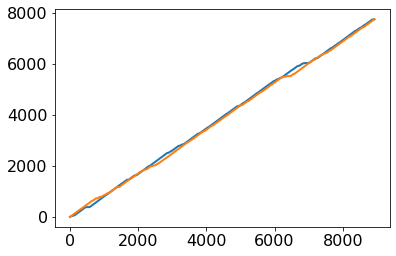

In [29]:
plt.plot(path_mais)

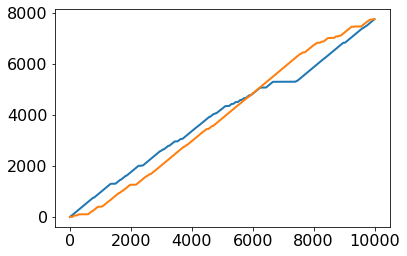

In [30]:
plt.plot(path_menos)

**Questão 3**

Plote os cromagramas da músicas mais e menos similar. Compare com a versão base.

> Qual interpretação você tira do plot?

> É mais difícil comparar com um tempo mais longo (3 minutos), mas a de Stan Getz tem o cromagrama bem parecido com o de Tony e Amy. Parece que o primeiro tem as intensidades mais acentuadas, mas mais ou menos nos mesmos lugares que o segundo. O terceiro, da música menos similar, já achei bem diferente.

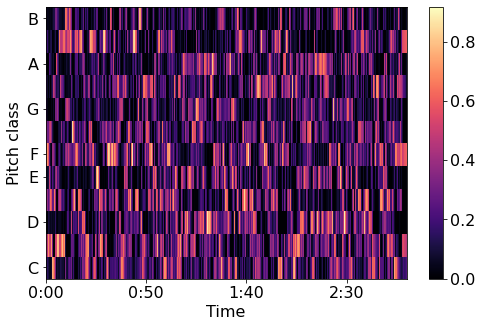

In [31]:
fig, ax = plt.subplots(figsize=(1.618 * 5, 5))
img = librosa.display.specshow(chroma_mais,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

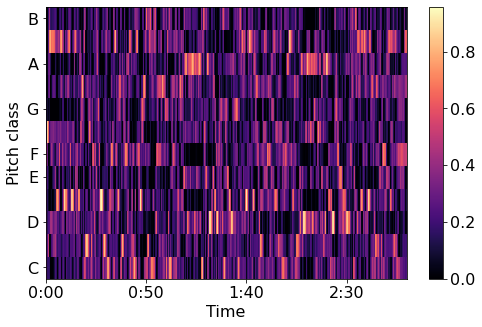

In [32]:
fig, ax = plt.subplots(figsize=(1.618 * 5, 5))
img = librosa.display.specshow(chroma_amy,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

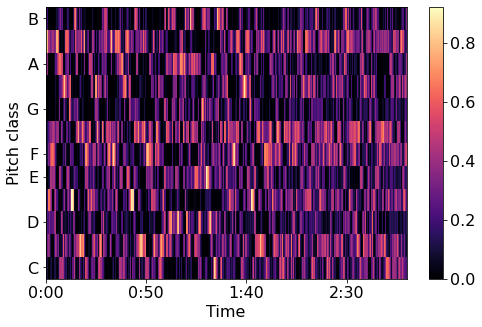

In [33]:
fig, ax = plt.subplots(figsize=(1.618 * 5, 5))
img = librosa.display.specshow(chroma_menos,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)